In [1]:
# https://docs.google.com/document/d/1M-b8mR-tgOQH4KHFdQu5GyN47CWR2edLV_5TZRM4nsg/edit?tab=t.0

In [4]:
!pip install ONE-api ibllib

from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import copy

ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

  Using cached one_api-3.0.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached ibllib-3.3.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached ruff-0.11.6-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached iblutil-1.17.0-py3-none-any.whl.metadata (967 bytes)
  Using cached flake8-7.2.0-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached globus_sdk-3.55.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached nptdms-1.10.0-py3-none-any.whl
  Using cached pynrrd-1.1.3-py3-none-any.whl.metadata (5.4 kB)
  Using cached imagecodecs-2025.3.30-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached sparse-0.16.0-py2.py3-none-any.whl.metadata (5.3 kB)
  Using cached iblatlas-0.9.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached ibl_neuropixel-1.6.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached iblqt-0.4.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached mtscomp-1.0.2-py2.py3-none-any.whl.metadata (7.2 kB)
  Using cached

In [8]:
# Connect to the IBL database
one = ONE(base_url='https://openalyx.internationalbrainlab.org')
pid = '5246af08-0730-40f7-83de-29b5d62b9b6d'
ssl = SpikeSortingLoader(pid=pid, one=one)

# Extract LFP segments around stimOn_times (includes high-pass filtering and z-scoring)
def extract_lfp_segments(sr_lf, stimOn_times, window=0.75):
    fs = sr_lf.fs
    segments = []
    for t_event in stimOn_times:
        s_event = int(t_event * fs)
        first = s_event + int(window * -fs)
        last = s_event + int(window * fs)
        if first < 0 or last > sr_lf.shape[0]:
            continue
        raw_lf = sr_lf[first:last, :-sr_lf.nsync].T
        sos_lf = scipy.signal.butter(3, 2 / fs / 2, btype='highpass', output='sos')
        filtered_lf = scipy.signal.sosfiltfilt(sos_lf, raw_lf)
        filtered_lf = (filtered_lf - np.mean(filtered_lf, axis=1, keepdims=True)) / (np.std(filtered_lf, axis=1, keepdims=True) + 1e-6)
        segments.append(filtered_lf)
    return segments

# Load stimOn_times and wheel data
# eid = one.pid2eid(pid)
eid = 'c51f34d8-42f6-4c9c-bb5b-669fd9c42cd9'
trials = one.load_object(eid, 'trials', collection='alf')
stimOn_times = trials['stimOn_times']
stimOn_times = stimOn_times[~np.isnan(stimOn_times)]
wheel = one.load_object(eid, 'wheel', collection='alf')

# Extract LFP segments
sr_lf = ssl.raw_electrophysiology(band="lf", stream=True)
lfp_segments = extract_lfp_segments(sr_lf, stimOn_times, window=0.75)


(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.lf.ch: 100%|██████████| 115k/115k [00:00<00:00, 535kB/s]
(S3) /root/Downloads/ONE/openalyx.internationalbrainlab.org/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/_spikeglx_ephysData_g0_t0.imec0.lf.meta: 100%|██████████| 13.9k/13.9k [00:00<00:00, 83.1kB/s]


2025-04-22 02:30:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000065_to_000066/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1073286


100%|██████████| 1.0235652923583984/1.0235652923583984 [00:00<00:00,  3.44it/s]

2025-04-22 02:30:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000068_to_000069/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1198237


100%|██████████| 1.1427278518676758/1.1427278518676758 [00:00<00:00,  3.82it/s]

2025-04-22 02:30:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000070_to_000072/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2072562


100%|██████████| 1.9765491485595703/1.9765491485595703 [00:00<00:00,  5.68it/s]

2025-04-22 02:30:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000077_to_000078/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1372278


100%|██████████| 1.308706283569336/1.308706283569336 [00:00<00:00,  3.63it/s]

2025-04-22 02:30:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000080_to_000081/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1408508


100%|██████████| 1.3432579040527344/1.3432579040527344 [00:00<00:00,  4.51it/s]

2025-04-22 02:30:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000095_to_000097/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1998862


100%|██████████| 1.9062633514404297/1.9062633514404297 [00:00<00:00,  5.47it/s]

2025-04-22 02:30:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000098_to_000100/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2085902


100%|██████████| 1.9892711639404297/1.9892711639404297 [00:00<00:00,  6.07it/s]

2025-04-22 02:30:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000102_to_000103/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1368683


100%|██████████| 1.3052778244018555/1.3052778244018555 [00:00<00:00,  4.38it/s]

2025-04-22 02:30:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000105_to_000106/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1393115


100%|██████████| 1.328577995300293/1.328577995300293 [00:00<00:00,  4.45it/s]

2025-04-22 02:30:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000108_to_000109/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1372305


100%|██████████| 1.308732032775879/1.308732032775879 [00:00<00:00,  4.40it/s]

2025-04-22 02:30:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000111_to_000113/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2075187


100%|██████████| 1.9790525436401367/1.9790525436401367 [00:00<00:00,  6.00it/s]

2025-04-22 02:30:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000114_to_000116/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2026445


100%|██████████| 1.9325685501098633/1.9325685501098633 [00:00<00:00,  5.57it/s]

2025-04-22 02:30:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000120_to_000122/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1751521


100%|██████████| 1.6703805923461914/1.6703805923461914 [00:00<00:00,  5.10it/s]

2025-04-22 02:30:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000127_to_000129/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1706301


100%|██████████| 1.6272554397583008/1.6272554397583008 [00:00<00:00,  4.95it/s]

2025-04-22 02:30:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000130_to_000132/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1955379


100%|██████████| 1.8647947311401367/1.8647947311401367 [00:00<00:00,  5.73it/s]

2025-04-22 02:30:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000134_to_000136/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1732468


100%|██████████| 1.6522102355957031/1.6522102355957031 [00:00<00:00,  5.46it/s]

2025-04-22 02:30:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000137_to_000139/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2103512


100%|██████████| 2.0060653686523438/2.0060653686523438 [00:00<00:00,  5.76it/s]

2025-04-22 02:30:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000141_to_000143/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1744118


100%|██████████| 1.663320541381836/1.663320541381836 [00:00<00:00,  5.55it/s]

2025-04-22 02:30:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000147_to_000149/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2102947


100%|██████████| 2.005526542663574/2.005526542663574 [00:00<00:00,  5.73it/s]

2025-04-22 02:30:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000150_to_000152/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2013931


100%|██████████| 1.9206342697143555/1.9206342697143555 [00:00<00:00,  5.53it/s]

2025-04-22 02:30:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000158_to_000159/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1355456


100%|██████████| 1.29266357421875/1.29266357421875 [00:00<00:00,  4.33it/s]

2025-04-22 02:30:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000161_to_000162/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1342964


100%|██████████| 1.2807502746582031/1.2807502746582031 [00:00<00:00,  4.29it/s]

2025-04-22 02:30:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000165_to_000167/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2009256


100%|██████████| 1.9161758422851562/1.9161758422851562 [00:00<00:00,  5.86it/s]

2025-04-22 02:30:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000171_to_000172/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1350049


100%|██████████| 1.2875070571899414/1.2875070571899414 [00:00<00:00,  4.31it/s]

2025-04-22 02:30:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000174_to_000175/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1330605


100%|██████████| 1.2689638137817383/1.2689638137817383 [00:00<00:00,  4.26it/s]

2025-04-22 02:30:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000178_to_000180/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1947411


100%|██████████| 1.8571958541870117/1.8571958541870117 [00:00<00:00,  5.67it/s]

2025-04-22 02:30:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000182_to_000183/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1369982


100%|██████████| 1.3065166473388672/1.3065166473388672 [00:00<00:00,  4.37it/s]

2025-04-22 02:30:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000186_to_000187/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1248731


100%|██████████| 1.190882682800293/1.190882682800293 [00:00<00:00,  4.00it/s]

2025-04-22 02:31:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000190_to_000192/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1761000


100%|██████████| 1.6794204711914062/1.6794204711914062 [00:00<00:00,  5.63it/s]

2025-04-22 02:31:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000193_to_000195/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2122021


100%|██████████| 2.023716926574707/2.023716926574707 [00:00<00:00,  6.19it/s]

2025-04-22 02:31:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000196_to_000198/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1995437


100%|██████████| 1.9029970169067383/1.9029970169067383 [00:00<00:00,  5.47it/s]

2025-04-22 02:31:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000203_to_000204/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1356065


100%|██████████| 1.2932443618774414/1.2932443618774414 [00:00<00:00,  4.35it/s]

2025-04-22 02:31:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000206_to_000207/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1381052


100%|██████████| 1.3170738220214844/1.3170738220214844 [00:00<00:00,  4.40it/s]

2025-04-22 02:31:03 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000208_to_000210/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2038323


100%|██████████| 1.9438962936401367/1.9438962936401367 [00:00<00:00,  5.58it/s]

2025-04-22 02:31:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000211_to_000213/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2007565


100%|██████████| 1.9145631790161133/1.9145631790161133 [00:00<00:00,  5.50it/s]

2025-04-22 02:31:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000215_to_000217/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1953986


100%|██████████| 1.8634662628173828/1.8634662628173828 [00:00<00:00,  5.68it/s]

2025-04-22 02:31:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000218_to_000220/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2019981


100%|██████████| 1.9264039993286133/1.9264039993286133 [00:00<00:00,  5.55it/s]

2025-04-22 02:31:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000221_to_000223/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1887553


100%|██████████| 1.8001108169555664/1.8001108169555664 [00:00<00:00,  5.17it/s]

2025-04-22 02:31:06 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000225_to_000227/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1869472


100%|██████████| 1.782867431640625/1.782867431640625 [00:00<00:00,  5.12it/s]

2025-04-22 02:31:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000236_to_000238/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1843712


100%|██████████| 1.75830078125/1.75830078125 [00:00<00:00,  5.72it/s]

2025-04-22 02:31:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000241_to_000242/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1341571


100%|██████████| 1.2794218063354492/1.2794218063354492 [00:00<00:00,  4.28it/s]

2025-04-22 02:31:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000244_to_000245/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1283268


100%|██████████| 1.2238197326660156/1.2238197326660156 [00:00<00:00,  4.10it/s]

2025-04-22 02:31:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000247_to_000249/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2068197


100%|██████████| 1.972386360168457/1.972386360168457 [00:00<00:00,  5.66it/s]

2025-04-22 02:31:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000250_to_000252/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1980957


100%|██████████| 1.8891878128051758/1.8891878128051758 [00:00<00:00,  5.79it/s]

2025-04-22 02:31:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000259_to_000261/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1888087


100%|██████████| 1.8006200790405273/1.8006200790405273 [00:00<00:00,  5.53it/s]

2025-04-22 02:31:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000262_to_000264/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1859099


100%|██████████| 1.772974967956543/1.772974967956543 [00:00<00:00,  5.45it/s]

2025-04-22 02:31:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000265_to_000267/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2015738


100%|██████████| 1.9223575592041016/1.9223575592041016 [00:00<00:00,  5.92it/s]

2025-04-22 02:31:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000269_to_000271/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1772468


100%|██████████| 1.6903572082519531/1.6903572082519531 [00:00<00:00,  5.21it/s]

2025-04-22 02:31:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000276_to_000277/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1382943


100%|██████████| 1.3188772201538086/1.3188772201538086 [00:00<00:00,  4.43it/s]

2025-04-22 02:31:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000279_to_000281/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2034506


100%|██████████| 1.940256118774414/1.940256118774414 [00:00<00:00,  5.61it/s]

2025-04-22 02:31:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000283_to_000284/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1299238


100%|██████████| 1.2390499114990234/1.2390499114990234 [00:00<00:00,  4.14it/s]

2025-04-22 02:31:14 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000289_to_000290/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1305332


100%|██████████| 1.2448616027832031/1.2448616027832031 [00:00<00:00,  4.17it/s]

2025-04-22 02:31:14 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000295_to_000296/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1281915


100%|██████████| 1.222529411315918/1.222529411315918 [00:00<00:00,  4.09it/s]

2025-04-22 02:31:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000299_to_000301/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1917256


100%|██████████| 1.8284378051757812/1.8284378051757812 [00:00<00:00,  5.28it/s]

2025-04-22 02:31:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000302_to_000304/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2000981


100%|██████████| 1.9082841873168945/1.9082841873168945 [00:00<00:00,  5.74it/s]

2025-04-22 02:31:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000306_to_000307/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1297281


100%|██████████| 1.2371835708618164/1.2371835708618164 [00:00<00:00,  4.14it/s]

2025-04-22 02:31:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000310_to_000311/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1243997


100%|██████████| 1.1863679885864258/1.1863679885864258 [00:00<00:00,  3.99it/s]

2025-04-22 02:31:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000313_to_000315/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2012547


100%|██████████| 1.9193143844604492/1.9193143844604492 [00:00<00:00,  5.89it/s]

2025-04-22 02:31:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000317_to_000318/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1276590


100%|██████████| 1.2174510955810547/1.2174510955810547 [00:00<00:00,  4.09it/s]

2025-04-22 02:31:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000320_to_000321/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1296246


100%|██████████| 1.236196517944336/1.236196517944336 [00:00<00:00,  4.15it/s]

2025-04-22 02:31:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000327_to_000328/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1279768


100%|██████████| 1.2204818725585938/1.2204818725585938 [00:00<00:00,  4.09it/s]

2025-04-22 02:31:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000330_to_000332/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1947025


100%|██████████| 1.856827735900879/1.856827735900879 [00:00<00:00,  5.71it/s]

2025-04-22 02:31:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000335_to_000336/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1234658


100%|██████████| 1.1774616241455078/1.1774616241455078 [00:00<00:00,  3.95it/s]

2025-04-22 02:31:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000342_to_000343/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1292302


100%|██████████| 1.2324352264404297/1.2324352264404297 [00:00<00:00,  4.12it/s]

2025-04-22 02:31:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000345_to_000346/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1324505


100%|██████████| 1.2631464004516602/1.2631464004516602 [00:00<00:00,  4.23it/s]

2025-04-22 02:31:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000348_to_000350/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1977173


100%|██████████| 1.8855791091918945/1.8855791091918945 [00:00<00:00,  5.81it/s]

2025-04-22 02:31:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000351_to_000352/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1338269


100%|██████████| 1.2762727737426758/1.2762727737426758 [00:00<00:00,  4.26it/s]

2025-04-22 02:31:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000354_to_000356/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1899955


100%|██████████| 1.8119382858276367/1.8119382858276367 [00:00<00:00,  5.20it/s]

2025-04-22 02:31:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000357_to_000359/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2004828


100%|██████████| 1.9119529724121094/1.9119529724121094 [00:00<00:00,  5.08it/s]

2025-04-22 02:31:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000360_to_000362/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1937175


100%|██████████| 1.8474340438842773/1.8474340438842773 [00:00<00:00,  5.31it/s]

2025-04-22 02:31:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000367_to_000369/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1913191


100%|██████████| 1.8245611190795898/1.8245611190795898 [00:00<00:00,  5.60it/s]

2025-04-22 02:31:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000370_to_000372/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2016412


100%|██████████| 1.9230003356933594/1.9230003356933594 [00:00<00:00,  5.91it/s]

2025-04-22 02:31:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000374_to_000376/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1953858


100%|██████████| 1.8633441925048828/1.8633441925048828 [00:00<00:00,  5.71it/s]

2025-04-22 02:31:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000377_to_000379/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1915073


100%|██████████| 1.8263559341430664/1.8263559341430664 [00:00<00:00,  5.57it/s]

2025-04-22 02:31:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000383_to_000385/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1893813


100%|██████████| 1.8060808181762695/1.8060808181762695 [00:00<00:00,  5.20it/s]

2025-04-22 02:31:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000386_to_000388/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1959268


100%|██████████| 1.8685035705566406/1.8685035705566406 [00:00<00:00,  5.37it/s]

2025-04-22 02:31:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000389_to_000391/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1998772


100%|██████████| 1.9061775207519531/1.9061775207519531 [00:00<00:00,  5.48it/s]

2025-04-22 02:31:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000392_to_000393/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1320175


100%|██████████| 1.259016990661621/1.259016990661621 [00:00<00:00,  4.21it/s]

2025-04-22 02:31:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000395_to_000397/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1939782


100%|██████████| 1.8499202728271484/1.8499202728271484 [00:00<00:00,  5.67it/s]

2025-04-22 02:31:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000399_to_000400/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1310114


100%|██████████| 1.2494220733642578/1.2494220733642578 [00:00<00:00,  4.20it/s]

2025-04-22 02:31:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000402_to_000404/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1956729


100%|██████████| 1.8660821914672852/1.8660821914672852 [00:00<00:00,  5.75it/s]

2025-04-22 02:31:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000405_to_000407/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1931242


100%|██████████| 1.841775894165039/1.841775894165039 [00:00<00:00,  5.67it/s]

2025-04-22 02:31:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000410_to_000411/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1285930


100%|██████████| 1.226358413696289/1.226358413696289 [00:00<00:00,  4.10it/s]

2025-04-22 02:31:33 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000413_to_000414/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1302163


100%|██████████| 1.2418394088745117/1.2418394088745117 [00:00<00:00,  4.16it/s]

2025-04-22 02:31:34 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000417_to_000418/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1255056


100%|██████████| 1.1969146728515625/1.1969146728515625 [00:00<00:00,  4.02it/s]

2025-04-22 02:31:34 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000422_to_000423/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1232452


100%|██████████| 1.1753578186035156/1.1753578186035156 [00:00<00:00,  3.93it/s]

2025-04-22 02:31:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000425_to_000427/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1995341


100%|██████████| 1.9029054641723633/1.9029054641723633 [00:00<00:00,  5.84it/s]

2025-04-22 02:31:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000428_to_000429/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1323635


100%|██████████| 1.2623167037963867/1.2623167037963867 [00:00<00:00,  4.22it/s]

2025-04-22 02:31:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000431_to_000432/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1294917


100%|██████████| 1.234929084777832/1.234929084777832 [00:00<00:00,  4.13it/s]

2025-04-22 02:31:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000436_to_000438/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1954924


100%|██████████| 1.8643608093261719/1.8643608093261719 [00:00<00:00,  5.35it/s]

2025-04-22 02:31:37 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000440_to_000442/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1883929


100%|██████████| 1.7966547012329102/1.7966547012329102 [00:00<00:00,  5.50it/s]

2025-04-22 02:31:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000443_to_000445/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1893804


100%|██████████| 1.8060722351074219/1.8060722351074219 [00:00<00:00,  5.54it/s]

2025-04-22 02:31:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000447_to_000449/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1889198


100%|██████████| 1.8016796112060547/1.8016796112060547 [00:00<00:00,  5.53it/s]

2025-04-22 02:31:39 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000452_to_000453/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1265572


100%|██████████| 1.2069435119628906/1.2069435119628906 [00:00<00:00,  4.04it/s]

2025-04-22 02:31:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000456_to_000457/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1250529


100%|██████████| 1.1925973892211914/1.1925973892211914 [00:00<00:00,  3.98it/s]

2025-04-22 02:31:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000460_to_000462/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1952529


100%|██████████| 1.862076759338379/1.862076759338379 [00:00<00:00,  5.73it/s]

2025-04-22 02:31:41 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000465_to_000467/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1919680


100%|██████████| 1.83074951171875/1.83074951171875 [00:00<00:00,  5.24it/s]

2025-04-22 02:31:41 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000469_to_000470/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1341574


100%|██████████| 1.2794246673583984/1.2794246673583984 [00:00<00:00,  4.27it/s]

2025-04-22 02:31:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000472_to_000473/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1335702


100%|██████████| 1.273824691772461/1.273824691772461 [00:00<00:00,  3.90it/s]

2025-04-22 02:31:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000475_to_000477/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1941808


100%|██████████| 1.8518524169921875/1.8518524169921875 [00:00<00:00,  5.69it/s]

2025-04-22 02:31:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000482_to_000483/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1264079


100%|██████████| 1.205519676208496/1.205519676208496 [00:00<00:00,  4.06it/s]

2025-04-22 02:31:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000485_to_000487/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1987299


100%|██████████| 1.8952360153198242/1.8952360153198242 [00:00<00:00,  5.45it/s]

2025-04-22 02:31:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000488_to_000490/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1932572


100%|██████████| 1.8430442810058594/1.8430442810058594 [00:00<00:00,  5.66it/s]

2025-04-22 02:31:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000491_to_000493/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1962982


100%|██████████| 1.8720455169677734/1.8720455169677734 [00:00<00:00,  5.38it/s]

2025-04-22 02:31:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000495_to_000496/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1307012


100%|██████████| 1.2464637756347656/1.2464637756347656 [00:00<00:00,  4.16it/s]

2025-04-22 02:31:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000498_to_000499/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1311573


100%|██████████| 1.2508134841918945/1.2508134841918945 [00:00<00:00,  4.18it/s]

2025-04-22 02:31:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000504_to_000505/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1182087


100%|██████████| 1.1273260116577148/1.1273260116577148 [00:00<00:00,  3.78it/s]

2025-04-22 02:31:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000508_to_000510/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1909222


100%|██████████| 1.8207759857177734/1.8207759857177734 [00:00<00:00,  5.57it/s]

2025-04-22 02:31:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000512_to_000514/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1758908


100%|██████████| 1.6774253845214844/1.6774253845214844 [00:00<00:00,  5.16it/s]

2025-04-22 02:31:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000521_to_000523/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1987440


100%|██████████| 1.8953704833984375/1.8953704833984375 [00:00<00:00,  6.25it/s]

2025-04-22 02:31:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000524_to_000526/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1984506


100%|██████████| 1.8925724029541016/1.8925724029541016 [00:00<00:00,  5.43it/s]

2025-04-22 02:31:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000527_to_000529/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2014495


100%|██████████| 1.9211721420288086/1.9211721420288086 [00:00<00:00,  5.90it/s]

2025-04-22 02:31:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000530_to_000532/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1966028


100%|██████████| 1.8749504089355469/1.8749504089355469 [00:00<00:00,  5.75it/s]

2025-04-22 02:31:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000535_to_000536/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1259723


100%|██████████| 1.2013654708862305/1.2013654708862305 [00:00<00:00,  4.01it/s]

2025-04-22 02:31:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000538_to_000539/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1304718


100%|██████████| 1.2442760467529297/1.2442760467529297 [00:00<00:00,  4.17it/s]

2025-04-22 02:31:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000542_to_000543/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1300502


100%|██████████| 1.240255355834961/1.240255355834961 [00:00<00:00,  4.16it/s]

2025-04-22 02:31:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000547_to_000548/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1265677


100%|██████████| 1.2070436477661133/1.2070436477661133 [00:00<00:00,  4.05it/s]

2025-04-22 02:31:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000550_to_000551/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1310635


100%|██████████| 1.2499189376831055/1.2499189376831055 [00:00<00:00,  4.18it/s]

2025-04-22 02:31:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000553_to_000554/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1280815


100%|██████████| 1.221480369567871/1.221480369567871 [00:00<00:00,  4.08it/s]

2025-04-22 02:31:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000558_to_000560/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1957265


100%|██████████| 1.866593360900879/1.866593360900879 [00:00<00:00,  5.75it/s]

2025-04-22 02:31:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000561_to_000563/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1873186


100%|██████████| 1.7864093780517578/1.7864093780517578 [00:00<00:00,  5.55it/s]

2025-04-22 02:31:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000566_to_000568/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1856583


100%|██████████| 1.7705755233764648/1.7705755233764648 [00:00<00:00,  5.47it/s]

2025-04-22 02:31:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000570_to_000572/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1899399


100%|██████████| 1.8114080429077148/1.8114080429077148 [00:00<00:00,  5.59it/s]

2025-04-22 02:31:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000573_to_000575/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1950998


100%|██████████| 1.860616683959961/1.860616683959961 [00:00<00:00,  5.75it/s]

2025-04-22 02:31:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000577_to_000578/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1322279


100%|██████████| 1.2610235214233398/1.2610235214233398 [00:00<00:00,  4.23it/s]

2025-04-22 02:31:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000581_to_000582/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1281234


100%|██████████| 1.2218799591064453/1.2218799591064453 [00:00<00:00,  4.08it/s]

2025-04-22 02:31:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000585_to_000587/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1911601


100%|██████████| 1.823044776916504/1.823044776916504 [00:00<00:00,  5.65it/s]

2025-04-22 02:31:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000588_to_000590/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1956881


100%|██████████| 1.866227149963379/1.866227149963379 [00:00<00:00,  5.75it/s]

2025-04-22 02:32:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000592_to_000594/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1917747


100%|██████████| 1.8289060592651367/1.8289060592651367 [00:00<00:00,  5.26it/s]

2025-04-22 02:32:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000595_to_000597/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2015017


100%|██████████| 1.9216699600219727/1.9216699600219727 [00:00<00:00,  5.89it/s]

2025-04-22 02:32:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000599_to_000600/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1294981


100%|██████████| 1.234990119934082/1.234990119934082 [00:00<00:00,  4.16it/s]

2025-04-22 02:32:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000603_to_000604/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1284329


100%|██████████| 1.2248315811157227/1.2248315811157227 [00:00<00:00,  4.11it/s]

2025-04-22 02:32:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000606_to_000608/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2010352


100%|██████████| 1.9172210693359375/1.9172210693359375 [00:00<00:00,  5.91it/s]

2025-04-22 02:32:03 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000609_to_000611/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1999880


100%|██████████| 1.9072341918945312/1.9072341918945312 [00:00<00:00,  5.46it/s]

2025-04-22 02:32:03 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000613_to_000614/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1307064


100%|██████████| 1.2465133666992188/1.2465133666992188 [00:00<00:00,  4.18it/s]

2025-04-22 02:32:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000616_to_000618/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1852338


100%|██████████| 1.7665271759033203/1.7665271759033203 [00:00<00:00,  5.44it/s]

2025-04-22 02:32:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000623_to_000624/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1270587


100%|██████████| 1.211726188659668/1.211726188659668 [00:00<00:00,  4.05it/s]

2025-04-22 02:32:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000626_to_000628/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1886102


100%|██████████| 1.798727035522461/1.798727035522461 [00:00<00:00,  5.56it/s]

2025-04-22 02:32:06 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000629_to_000631/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1952571


100%|██████████| 1.862116813659668/1.862116813659668 [00:00<00:00,  5.71it/s]

2025-04-22 02:32:06 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000633_to_000634/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1342853


100%|██████████| 1.280644416809082/1.280644416809082 [00:00<00:00,  4.27it/s]

2025-04-22 02:32:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000636_to_000637/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1336877


100%|██████████| 1.2749452590942383/1.2749452590942383 [00:00<00:00,  4.26it/s]

2025-04-22 02:32:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000639_to_000640/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1332052


100%|██████████| 1.2703437805175781/1.2703437805175781 [00:00<00:00,  4.25it/s]

2025-04-22 02:32:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000645_to_000647/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1940049


100%|██████████| 1.850174903869629/1.850174903869629 [00:00<00:00,  5.68it/s]

2025-04-22 02:32:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000648_to_000650/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1931555


100%|██████████| 1.8420743942260742/1.8420743942260742 [00:00<00:00,  5.65it/s]

2025-04-22 02:32:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000653_to_000654/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1248668


100%|██████████| 1.1908226013183594/1.1908226013183594 [00:00<00:00,  3.99it/s]

2025-04-22 02:32:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000657_to_000658/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1254755


100%|██████████| 1.1966276168823242/1.1966276168823242 [00:00<00:00,  4.01it/s]

2025-04-22 02:32:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000661_to_000662/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1259177


100%|██████████| 1.2008447647094727/1.2008447647094727 [00:00<00:00,  4.03it/s]

2025-04-22 02:32:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000665_to_000666/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1271538


100%|██████████| 1.2126331329345703/1.2126331329345703 [00:00<00:00,  4.07it/s]

2025-04-22 02:32:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000668_to_000669/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1364015


100%|██████████| 1.300826072692871/1.300826072692871 [00:00<00:00,  4.34it/s]

2025-04-22 02:32:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000672_to_000674/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1940911


100%|██████████| 1.850996971130371/1.850996971130371 [00:00<00:00,  5.30it/s]

2025-04-22 02:32:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000675_to_000677/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1968836


100%|██████████| 1.8776283264160156/1.8776283264160156 [00:00<00:00,  5.76it/s]

2025-04-22 02:32:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000679_to_000681/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1967879


100%|██████████| 1.8767156600952148/1.8767156600952148 [00:00<00:00,  5.78it/s]

2025-04-22 02:32:14 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000683_to_000684/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1264146


100%|██████████| 1.2055835723876953/1.2055835723876953 [00:00<00:00,  4.05it/s]

2025-04-22 02:32:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000688_to_000689/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1291478


100%|██████████| 1.231649398803711/1.231649398803711 [00:00<00:00,  4.14it/s]

2025-04-22 02:32:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000691_to_000693/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1905503


100%|██████████| 1.8172292709350586/1.8172292709350586 [00:00<00:00,  5.61it/s]

2025-04-22 02:32:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000696_to_000698/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1970027


100%|██████████| 1.8787641525268555/1.8787641525268555 [00:00<00:00,  5.40it/s]

2025-04-22 02:32:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000701_to_000702/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1310687


100%|██████████| 1.2499685287475586/1.2499685287475586 [00:00<00:00,  4.20it/s]

2025-04-22 02:32:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000704_to_000705/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1340998


100%|██████████| 1.2788753509521484/1.2788753509521484 [00:00<00:00,  4.27it/s]

2025-04-22 02:32:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000709_to_000711/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1867262


100%|██████████| 1.7807598114013672/1.7807598114013672 [00:00<00:00,  5.09it/s]

2025-04-22 02:32:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000714_to_000715/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1251027


100%|██████████| 1.1930723190307617/1.1930723190307617 [00:00<00:00,  4.01it/s]

2025-04-22 02:32:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000717_to_000718/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1365567


100%|██████████| 1.3023061752319336/1.3023061752319336 [00:00<00:00,  4.36it/s]

2025-04-22 02:32:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000721_to_000722/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1241073


100%|██████████| 1.183579444885254/1.183579444885254 [00:00<00:00,  3.98it/s]

2025-04-22 02:32:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000724_to_000726/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1895798


100%|██████████| 1.807973861694336/1.807973861694336 [00:00<00:00,  5.45it/s]

2025-04-22 02:32:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000738_to_000740/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1792703


100%|██████████| 1.7096548080444336/1.7096548080444336 [00:00<00:00,  5.21it/s]

2025-04-22 02:32:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000749_to_000750/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1288615


100%|██████████| 1.2289190292358398/1.2289190292358398 [00:00<00:00,  4.14it/s]

2025-04-22 02:32:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000753_to_000755/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1839658


100%|██████████| 1.754434585571289/1.754434585571289 [00:00<00:00,  5.40it/s]

2025-04-22 02:32:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000760_to_000761/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1042279


100%|██████████| 0.9939947128295898/0.9939947128295898 [00:00<00:00,  3.33it/s]

2025-04-22 02:32:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000769_to_000771/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1585123


100%|██████████| 1.5116910934448242/1.5116910934448242 [00:00<00:00,  4.51it/s]

2025-04-22 02:32:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000821_to_000822/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1343348


100%|██████████| 1.2811164855957031/1.2811164855957031 [00:00<00:00,  4.30it/s]

2025-04-22 02:32:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000824_to_000825/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1333490


100%|██████████| 1.2717151641845703/1.2717151641845703 [00:00<00:00,  4.25it/s]

2025-04-22 02:32:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000829_to_000830/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1274597


100%|██████████| 1.215550422668457/1.215550422668457 [00:00<00:00,  4.05it/s]

2025-04-22 02:32:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000832_to_000833/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1294767


100%|██████████| 1.234786033630371/1.234786033630371 [00:00<00:00,  4.13it/s]

2025-04-22 02:32:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000836_to_000837/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1274441


100%|██████████| 1.2154016494750977/1.2154016494750977 [00:00<00:00,  4.06it/s]

2025-04-22 02:32:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000840_to_000841/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1209003


100%|██████████| 1.1529951095581055/1.1529951095581055 [00:00<00:00,  3.85it/s]

2025-04-22 02:32:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000844_to_000846/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1947653


100%|██████████| 1.857426643371582/1.857426643371582 [00:00<00:00,  5.57it/s]

2025-04-22 02:32:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000848_to_000849/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1362713


100%|██████████| 1.2995843887329102/1.2995843887329102 [00:00<00:00,  4.37it/s]

2025-04-22 02:32:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000850_to_000852/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1932037


100%|██████████| 1.842534065246582/1.842534065246582 [00:00<00:00,  5.53it/s]

2025-04-22 02:32:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000856_to_000857/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1248119


100%|██████████| 1.1902990341186523/1.1902990341186523 [00:00<00:00,  4.00it/s]

2025-04-22 02:32:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000860_to_000861/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1296865


100%|██████████| 1.2367868423461914/1.2367868423461914 [00:00<00:00,  4.16it/s]

2025-04-22 02:32:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000862_to_000864/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2075228


100%|██████████| 1.9790916442871094/1.9790916442871094 [00:00<00:00,  5.71it/s]

2025-04-22 02:32:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000866_to_000867/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1299378


100%|██████████| 1.2391834259033203/1.2391834259033203 [00:00<00:00,  4.14it/s]

2025-04-22 02:32:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000869_to_000871/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2010763


100%|██████████| 1.9176130294799805/1.9176130294799805 [00:00<00:00,  5.49it/s]

2025-04-22 02:32:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000872_to_000874/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2040739


100%|██████████| 1.9462003707885742/1.9462003707885742 [00:00<00:00,  5.85it/s]

2025-04-22 02:32:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000876_to_000877/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1314902


100%|██████████| 1.253988265991211/1.253988265991211 [00:00<00:00,  4.21it/s]

2025-04-22 02:32:33 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000879_to_000880/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1246047


100%|██████████| 1.1883230209350586/1.1883230209350586 [00:00<00:00,  3.98it/s]

2025-04-22 02:32:33 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000882_to_000884/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2006230


100%|██████████| 1.913290023803711/1.913290023803711 [00:00<00:00,  5.76it/s]

2025-04-22 02:32:34 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000886_to_000887/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1237601


100%|██████████| 1.1802682876586914/1.1802682876586914 [00:00<00:00,  3.96it/s]

2025-04-22 02:32:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000889_to_000891/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1990312


100%|██████████| 1.8981094360351562/1.8981094360351562 [00:00<00:00,  5.75it/s]

2025-04-22 02:32:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000893_to_000894/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1328949


100%|██████████| 1.2673845291137695/1.2673845291137695 [00:00<00:00,  4.25it/s]

2025-04-22 02:32:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000897_to_000899/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1944047


100%|██████████| 1.853987693786621/1.853987693786621 [00:00<00:00,  5.33it/s]

2025-04-22 02:32:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000900_to_000901/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1325293


100%|██████████| 1.2638978958129883/1.2638978958129883 [00:00<00:00,  4.21it/s]

2025-04-22 02:32:37 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000908_to_000910/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1881724


100%|██████████| 1.7945518493652344/1.7945518493652344 [00:00<00:00,  5.41it/s]

2025-04-22 02:32:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000913_to_000914/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1324457


100%|██████████| 1.2631006240844727/1.2631006240844727 [00:00<00:00,  4.23it/s]

2025-04-22 02:32:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000915_to_000917/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1826959


100%|██████████| 1.742323875427246/1.742323875427246 [00:00<00:00,  5.84it/s]

2025-04-22 02:32:39 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000920_to_000921/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1197697


100%|██████████| 1.1422128677368164/1.1422128677368164 [00:00<00:00,  3.85it/s]

2025-04-22 02:32:39 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000924_to_000925/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1308794


100%|██████████| 1.2481632232666016/1.2481632232666016 [00:00<00:00,  4.18it/s]

2025-04-22 02:32:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000927_to_000929/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2021095


100%|██████████| 1.9274663925170898/1.9274663925170898 [00:00<00:00,  5.88it/s]

2025-04-22 02:32:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000931_to_000933/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1981616


100%|██████████| 1.8898162841796875/1.8898162841796875 [00:00<00:00,  5.46it/s]

2025-04-22 02:32:41 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000934_to_000936/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2022411


100%|██████████| 1.9287214279174805/1.9287214279174805 [00:00<00:00,  5.56it/s]

2025-04-22 02:32:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000937_to_000939/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1951917


100%|██████████| 1.8614931106567383/1.8614931106567383 [00:00<00:00,  5.72it/s]

2025-04-22 02:32:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000942_to_000944/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1885773


100%|██████████| 1.7984132766723633/1.7984132766723633 [00:00<00:00,  5.49it/s]

2025-04-22 02:32:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000947_to_000949/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1892316


100%|██████████| 1.8046531677246094/1.8046531677246094 [00:00<00:00,  5.49it/s]

2025-04-22 02:32:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000951_to_000953/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1825073


100%|██████████| 1.740525245666504/1.740525245666504 [00:00<00:00,  5.01it/s]

2025-04-22 02:32:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000955_to_000956/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1246190


100%|██████████| 1.1884593963623047/1.1884593963623047 [00:00<00:00,  3.97it/s]

2025-04-22 02:32:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000958_to_000960/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2002952


100%|██████████| 1.9101638793945312/1.9101638793945312 [00:00<00:00,  5.49it/s]

2025-04-22 02:32:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000961_to_000963/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1990379


100%|██████████| 1.8981733322143555/1.8981733322143555 [00:00<00:00,  5.78it/s]

2025-04-22 02:32:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000965_to_000966/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1312850


100%|██████████| 1.2520313262939453/1.2520313262939453 [00:00<00:00,  4.20it/s]

2025-04-22 02:32:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000967_to_000969/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1960006


100%|██████████| 1.8692073822021484/1.8692073822021484 [00:00<00:00,  5.67it/s]

2025-04-22 02:32:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000970_to_000972/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2018184


100%|██████████| 1.9246902465820312/1.9246902465820312 [00:00<00:00,  5.87it/s]

2025-04-22 02:32:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000976_to_000977/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1335056


100%|██████████| 1.2732086181640625/1.2732086181640625 [00:00<00:00,  4.27it/s]

2025-04-22 02:32:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000979_to_000980/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1244522


100%|██████████| 1.186868667602539/1.186868667602539 [00:00<00:00,  3.97it/s]

2025-04-22 02:32:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000982_to_000984/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1717551


100%|██████████| 1.637984275817871/1.637984275817871 [00:00<00:00,  5.01it/s]

2025-04-22 02:32:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000991_to_000992/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1282763


100%|██████████| 1.2233381271362305/1.2233381271362305 [00:00<00:00,  4.10it/s]

2025-04-22 02:32:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_000996_to_000998/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1899701


100%|██████████| 1.8116960525512695/1.8116960525512695 [00:00<00:00,  5.54it/s]

2025-04-22 02:32:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001000_to_001001/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1341290


100%|██████████| 1.279153823852539/1.279153823852539 [00:00<00:00,  4.29it/s]

2025-04-22 02:32:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001002_to_001004/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2005625


100%|██████████| 1.9127130508422852/1.9127130508422852 [00:00<00:00,  5.51it/s]

2025-04-22 02:32:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001006_to_001007/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1339255


100%|██████████| 1.2772130966186523/1.2772130966186523 [00:00<00:00,  4.28it/s]

2025-04-22 02:32:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001009_to_001010/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1262782


100%|██████████| 1.2042827606201172/1.2042827606201172 [00:00<00:00,  4.04it/s]

2025-04-22 02:32:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001013_to_001015/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1944463


100%|██████████| 1.854384422302246/1.854384422302246 [00:00<00:00,  5.33it/s]

2025-04-22 02:32:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001016_to_001018/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1968698


100%|██████████| 1.8774967193603516/1.8774967193603516 [00:00<00:00,  5.41it/s]

2025-04-22 02:32:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001021_to_001023/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1759154


100%|██████████| 1.6776599884033203/1.6776599884033203 [00:00<00:00,  5.15it/s]

2025-04-22 02:32:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001025_to_001027/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1885630


100%|██████████| 1.7982769012451172/1.7982769012451172 [00:00<00:00,  5.52it/s]

2025-04-22 02:32:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001030_to_001031/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1190612


100%|██████████| 1.1354560852050781/1.1354560852050781 [00:00<00:00,  3.80it/s]

2025-04-22 02:32:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001033_to_001034/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1249764


100%|██████████| 1.1918678283691406/1.1918678283691406 [00:00<00:00,  3.98it/s]

2025-04-22 02:32:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001037_to_001038/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1266503


100%|██████████| 1.2078313827514648/1.2078313827514648 [00:00<00:00,  4.05it/s]

2025-04-22 02:32:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001041_to_001042/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1222053


100%|██████████| 1.165440559387207/1.165440559387207 [00:00<00:00,  3.92it/s]

2025-04-22 02:32:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001044_to_001046/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1946689


100%|██████████| 1.8565073013305664/1.8565073013305664 [00:00<00:00,  5.66it/s]

2025-04-22 02:32:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001050_to_001052/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1935518


100%|██████████| 1.8458538055419922/1.8458538055419922 [00:00<00:00,  5.31it/s]

2025-04-22 02:32:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001054_to_001055/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1274588


100%|██████████| 1.2155418395996094/1.2155418395996094 [00:00<00:00,  4.09it/s]

2025-04-22 02:33:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001061_to_001062/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1244548


100%|██████████| 1.1868934631347656/1.1868934631347656 [00:00<00:00,  3.99it/s]

2025-04-22 02:33:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001065_to_001066/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1216998


100%|██████████| 1.1606197357177734/1.1606197357177734 [00:00<00:00,  3.90it/s]

2025-04-22 02:33:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001068_to_001069/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1331438


100%|██████████| 1.2697582244873047/1.2697582244873047 [00:00<00:00,  4.23it/s]

2025-04-22 02:33:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001071_to_001073/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1997708


100%|██████████| 1.9051628112792969/1.9051628112792969 [00:00<00:00,  5.88it/s]

2025-04-22 02:33:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001075_to_001077/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1869838


100%|██████████| 1.7832164764404297/1.7832164764404297 [00:00<00:00,  5.47it/s]

2025-04-22 02:33:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001078_to_001080/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1941794


100%|██████████| 1.8518390655517578/1.8518390655517578 [00:00<00:00,  5.61it/s]

2025-04-22 02:33:03 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001087_to_001088/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1342363


100%|██████████| 1.280177116394043/1.280177116394043 [00:00<00:00,  4.30it/s]

2025-04-22 02:33:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001089_to_001091/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1861244


100%|██████████| 1.7750205993652344/1.7750205993652344 [00:00<00:00,  5.44it/s]

2025-04-22 02:33:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001097_to_001098/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1235374


100%|██████████| 1.1781444549560547/1.1781444549560547 [00:00<00:00,  3.95it/s]

2025-04-22 02:33:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001101_to_001102/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1225103


100%|██████████| 1.168349266052246/1.168349266052246 [00:00<00:00,  3.93it/s]

2025-04-22 02:33:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001104_to_001106/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1917605


100%|██████████| 1.828770637512207/1.828770637512207 [00:00<00:00,  5.27it/s]

2025-04-22 02:33:06 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001107_to_001109/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1988262


100%|██████████| 1.8961544036865234/1.8961544036865234 [00:00<00:00,  5.45it/s]

2025-04-22 02:33:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001111_to_001112/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1332483


100%|██████████| 1.2707548141479492/1.2707548141479492 [00:00<00:00,  4.26it/s]

2025-04-22 02:33:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001119_to_001120/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1194466


100%|██████████| 1.1391315460205078/1.1391315460205078 [00:00<00:00,  3.81it/s]

2025-04-22 02:33:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001131_to_001132/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1233896


100%|██████████| 1.1767349243164062/1.1767349243164062 [00:00<00:00,  3.93it/s]

2025-04-22 02:33:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001138_to_001139/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1272657


100%|██████████| 1.213700294494629/1.213700294494629 [00:00<00:00,  4.07it/s]

2025-04-22 02:33:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001153_to_001154/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1097835


100%|██████████| 1.0469770431518555/1.0469770431518555 [00:00<00:00,  3.53it/s]

2025-04-22 02:33:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001160_to_001162/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1625521


100%|██████████| 1.550217628479004/1.550217628479004 [00:00<00:00,  3.92it/s]

2025-04-22 02:33:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001166_to_001167/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1079433


100%|██████████| 1.0294275283813477/1.0294275283813477 [00:00<00:00,  3.46it/s]

2025-04-22 02:33:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001185_to_001187/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1692929


100%|██████████| 1.6145029067993164/1.6145029067993164 [00:00<00:00,  4.19it/s]

2025-04-22 02:33:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001189_to_001191/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1956843


100%|██████████| 1.8661909103393555/1.8661909103393555 [00:00<00:00,  5.67it/s]

2025-04-22 02:33:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001193_to_001194/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1347994


100%|██████████| 1.2855472564697266/1.2855472564697266 [00:00<00:00,  4.31it/s]

2025-04-22 02:33:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001199_to_001201/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1891245


100%|██████████| 1.8036317825317383/1.8036317825317383 [00:00<00:00,  5.49it/s]

2025-04-22 02:33:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001203_to_001205/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1784265


100%|██████████| 1.7016077041625977/1.7016077041625977 [00:00<00:00,  5.19it/s]

2025-04-22 02:33:14 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001208_to_001210/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1946468


100%|██████████| 1.8562965393066406/1.8562965393066406 [00:00<00:00,  5.34it/s]

2025-04-22 02:33:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001211_to_001213/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2043687


100%|██████████| 1.9490118026733398/1.9490118026733398 [00:00<00:00,  5.58it/s]

2025-04-22 02:33:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001215_to_001216/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1294653


100%|██████████| 1.2346773147583008/1.2346773147583008 [00:00<00:00,  4.12it/s]

2025-04-22 02:33:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001220_to_001222/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1821427


100%|██████████| 1.7370481491088867/1.7370481491088867 [00:00<00:00,  4.96it/s]

2025-04-22 02:33:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001223_to_001225/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2044570


100%|██████████| 1.9498538970947266/1.9498538970947266 [00:00<00:00,  5.96it/s]

2025-04-22 02:33:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001227_to_001229/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2030662


100%|██████████| 1.9365901947021484/1.9365901947021484 [00:00<00:00,  5.55it/s]

2025-04-22 02:33:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001230_to_001232/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2026204


100%|██████████| 1.9323387145996094/1.9323387145996094 [00:00<00:00,  5.91it/s]

2025-04-22 02:33:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001234_to_001236/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1890376


100%|██████████| 1.8028030395507812/1.8028030395507812 [00:00<00:00,  5.48it/s]

2025-04-22 02:33:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001237_to_001239/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2016035


100%|██████████| 1.9226408004760742/1.9226408004760742 [00:00<00:00,  5.83it/s]

2025-04-22 02:33:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001241_to_001243/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1962708


100%|██████████| 1.8717842102050781/1.8717842102050781 [00:00<00:00,  5.38it/s]

2025-04-22 02:33:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001244_to_001246/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2042152


100%|██████████| 1.9475479125976562/1.9475479125976562 [00:00<00:00,  5.59it/s]

2025-04-22 02:33:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001248_to_001249/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1334117


100%|██████████| 1.272313117980957/1.272313117980957 [00:00<00:00,  4.25it/s]

2025-04-22 02:33:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001254_to_001256/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1910198


100%|██████████| 1.821706771850586/1.821706771850586 [00:00<00:00,  5.59it/s]

2025-04-22 02:33:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001257_to_001259/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2049088


100%|██████████| 1.95416259765625/1.95416259765625 [00:00<00:00,  5.62it/s]

2025-04-22 02:33:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001261_to_001262/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1347642


100%|██████████| 1.2852115631103516/1.2852115631103516 [00:00<00:00,  4.29it/s]

2025-04-22 02:33:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001264_to_001265/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1326778


100%|██████████| 1.2653141021728516/1.2653141021728516 [00:00<00:00,  4.24it/s]

2025-04-22 02:33:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001267_to_001268/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1319851


100%|██████████| 1.2587080001831055/1.2587080001831055 [00:00<00:00,  4.21it/s]

2025-04-22 02:33:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001276_to_001278/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1842994


100%|██████████| 1.7576160430908203/1.7576160430908203 [00:00<00:00,  5.52it/s]

2025-04-22 02:33:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001280_to_001282/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1810993


100%|██████████| 1.727097511291504/1.727097511291504 [00:00<00:00,  4.95it/s]

2025-04-22 02:33:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001285_to_001287/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1884069


100%|██████████| 1.796788215637207/1.796788215637207 [00:00<00:00,  5.46it/s]

2025-04-22 02:33:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001290_to_001291/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1186400


100%|██████████| 1.131439208984375/1.131439208984375 [00:00<00:00,  3.81it/s]

2025-04-22 02:33:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001293_to_001295/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1944139


100%|██████████| 1.8540754318237305/1.8540754318237305 [00:00<00:00,  5.71it/s]

2025-04-22 02:33:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001296_to_001298/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1924862


100%|██████████| 1.8356914520263672/1.8356914520263672 [00:00<00:00,  5.27it/s]

2025-04-22 02:33:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001301_to_001303/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1862598


100%|██████████| 1.7763118743896484/1.7763118743896484 [00:00<00:00,  5.47it/s]

2025-04-22 02:33:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001306_to_001308/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1836667


100%|██████████| 1.751582145690918/1.751582145690918 [00:00<00:00,  5.39it/s]

2025-04-22 02:33:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001311_to_001313/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1828711


100%|██████████| 1.7439947128295898/1.7439947128295898 [00:00<00:00,  5.40it/s]

2025-04-22 02:33:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001315_to_001316/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1335444


100%|██████████| 1.2735786437988281/1.2735786437988281 [00:00<00:00,  4.27it/s]

2025-04-22 02:33:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001318_to_001320/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2006956


100%|██████████| 1.9139823913574219/1.9139823913574219 [00:00<00:00,  5.89it/s]

2025-04-22 02:33:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001325_to_001326/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1299751


100%|██████████| 1.2395391464233398/1.2395391464233398 [00:00<00:00,  4.15it/s]

2025-04-22 02:33:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001328_to_001329/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1293837


100%|██████████| 1.2338991165161133/1.2338991165161133 [00:00<00:00,  4.14it/s]

2025-04-22 02:33:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001331_to_001333/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2007551


100%|██████████| 1.9145498275756836/1.9145498275756836 [00:00<00:00,  5.89it/s]

2025-04-22 02:33:33 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001338_to_001340/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1992630


100%|██████████| 1.900320053100586/1.900320053100586 [00:00<00:00,  5.48it/s]

2025-04-22 02:33:33 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001342_to_001344/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2034937


100%|██████████| 1.9406671524047852/1.9406671524047852 [00:00<00:00,  5.56it/s]

2025-04-22 02:33:34 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001348_to_001350/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1961755


100%|██████████| 1.870875358581543/1.870875358581543 [00:00<00:00,  5.39it/s]

2025-04-22 02:33:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001352_to_001353/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1325681


100%|██████████| 1.264267921447754/1.264267921447754 [00:00<00:00,  4.25it/s]

2025-04-22 02:33:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001356_to_001357/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1324997


100%|██████████| 1.263615608215332/1.263615608215332 [00:00<00:00,  4.24it/s]

2025-04-22 02:33:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001360_to_001362/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1983063


100%|██████████| 1.8911962509155273/1.8911962509155273 [00:00<00:00,  5.75it/s]

2025-04-22 02:33:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001363_to_001364/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1297561


100%|██████████| 1.2374505996704102/1.2374505996704102 [00:00<00:00,  4.13it/s]

2025-04-22 02:33:37 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001368_to_001370/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1993382


100%|██████████| 1.9010372161865234/1.9010372161865234 [00:00<00:00,  5.76it/s]

2025-04-22 02:33:37 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001371_to_001373/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1990431


100%|██████████| 1.8982229232788086/1.8982229232788086 [00:00<00:00,  5.47it/s]

2025-04-22 02:33:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001374_to_001376/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1989999


100%|██████████| 1.897810935974121/1.897810935974121 [00:00<00:00,  5.85it/s]

2025-04-22 02:33:39 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001378_to_001379/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1311738


100%|██████████| 1.2509708404541016/1.2509708404541016 [00:00<00:00,  4.19it/s]

2025-04-22 02:33:39 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001383_to_001384/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1281674


100%|██████████| 1.222299575805664/1.222299575805664 [00:00<00:00,  4.10it/s]

2025-04-22 02:33:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001390_to_001391/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1270736


100%|██████████| 1.2118682861328125/1.2118682861328125 [00:00<00:00,  4.06it/s]

2025-04-22 02:33:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001394_to_001395/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1280120


100%|██████████| 1.2208175659179688/1.2208175659179688 [00:00<00:00,  4.09it/s]

2025-04-22 02:33:41 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001397_to_001398/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1282967


100%|██████████| 1.2235326766967773/1.2235326766967773 [00:00<00:00,  4.08it/s]

2025-04-22 02:33:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001406_to_001407/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1231088


100%|██████████| 1.1740570068359375/1.1740570068359375 [00:00<00:00,  3.96it/s]

2025-04-22 02:33:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001410_to_001411/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1233438


100%|██████████| 1.1762981414794922/1.1762981414794922 [00:00<00:00,  3.95it/s]

2025-04-22 02:33:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001413_to_001415/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1870968


100%|██████████| 1.7842941284179688/1.7842941284179688 [00:00<00:00,  5.48it/s]

2025-04-22 02:33:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001416_to_001418/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1968950


100%|██████████| 1.877737045288086/1.877737045288086 [00:00<00:00,  5.40it/s]

2025-04-22 02:33:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001424_to_001426/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1925059


100%|██████████| 1.8358793258666992/1.8358793258666992 [00:00<00:00,  4.51it/s]

2025-04-22 02:33:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001430_to_001431/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1187522


100%|██████████| 1.1325092315673828/1.1325092315673828 [00:00<00:00,  3.80it/s]

2025-04-22 02:33:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001433_to_001435/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1991079


100%|██████████| 1.8988409042358398/1.8988409042358398 [00:00<00:00,  5.45it/s]

2025-04-22 02:33:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001437_to_001438/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1296886


100%|██████████| 1.236806869506836/1.236806869506836 [00:00<00:00,  4.15it/s]

2025-04-22 02:33:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001441_to_001443/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1880883


100%|██████████| 1.7937498092651367/1.7937498092651367 [00:00<00:00,  5.48it/s]

2025-04-22 02:33:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001444_to_001446/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1940993


100%|██████████| 1.8510751724243164/1.8510751724243164 [00:00<00:00,  5.34it/s]

2025-04-22 02:33:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001455_to_001456/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1282983


100%|██████████| 1.2235479354858398/1.2235479354858398 [00:00<00:00,  4.10it/s]

2025-04-22 02:33:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001458_to_001459/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1320424


100%|██████████| 1.2592544555664062/1.2592544555664062 [00:00<00:00,  4.21it/s]

2025-04-22 02:33:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001462_to_001463/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1248729


100%|██████████| 1.1908807754516602/1.1908807754516602 [00:00<00:00,  3.99it/s]

2025-04-22 02:33:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001470_to_001472/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1836002


100%|██████████| 1.7509479522705078/1.7509479522705078 [00:00<00:00,  5.40it/s]

2025-04-22 02:33:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001476_to_001478/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1861598


100%|██████████| 1.7753582000732422/1.7753582000732422 [00:00<00:00,  5.32it/s]

2025-04-22 02:33:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001488_to_001489/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1302371


100%|██████████| 1.2420377731323242/1.2420377731323242 [00:00<00:00,  3.39it/s]

2025-04-22 02:33:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001497_to_001498/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1276081


100%|██████████| 1.216965675354004/1.216965675354004 [00:00<00:00,  3.90it/s]

2025-04-22 02:33:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001507_to_001508/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1099647


100%|██████████| 1.0487051010131836/1.0487051010131836 [00:00<00:00,  3.54it/s]

2025-04-22 02:33:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001529_to_001531/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1684749


100%|██████████| 1.6067018508911133/1.6067018508911133 [00:00<00:00,  4.80it/s]

2025-04-22 02:33:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001550_to_001552/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2005324


100%|██████████| 1.9124259948730469/1.9124259948730469 [00:00<00:00,  4.92it/s]

2025-04-22 02:33:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001556_to_001557/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1300726


100%|██████████| 1.240468978881836/1.240468978881836 [00:00<00:00,  4.15it/s]

2025-04-22 02:33:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001561_to_001563/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1998910


100%|██████████| 1.9063091278076172/1.9063091278076172 [00:00<00:00,  5.88it/s]

2025-04-22 02:33:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001568_to_001570/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1874672


100%|██████████| 1.7878265380859375/1.7878265380859375 [00:00<00:00,  5.14it/s]

2025-04-22 02:33:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001571_to_001573/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1947131


100%|██████████| 1.856928825378418/1.856928825378418 [00:00<00:00,  5.67it/s]

2025-04-22 02:33:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001577_to_001579/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1892684


100%|██████████| 1.8050041198730469/1.8050041198730469 [00:00<00:00,  5.53it/s]

2025-04-22 02:33:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001583_to_001584/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1253576


100%|██████████| 1.1955032348632812/1.1955032348632812 [00:00<00:00,  3.99it/s]

2025-04-22 02:33:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001586_to_001588/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1961458


100%|██████████| 1.8705921173095703/1.8705921173095703 [00:00<00:00,  5.75it/s]

2025-04-22 02:33:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001589_to_001591/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2016550


100%|██████████| 1.9231319427490234/1.9231319427490234 [00:00<00:00,  5.51it/s]

2025-04-22 02:33:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001592_to_001594/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1987846


100%|██████████| 1.8957576751708984/1.8957576751708984 [00:00<00:00,  5.83it/s]

2025-04-22 02:33:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001601_to_001603/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1884626


100%|██████████| 1.7973194122314453/1.7973194122314453 [00:00<00:00,  5.16it/s]

2025-04-22 02:34:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001606_to_001608/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1916486


100%|██████████| 1.8277034759521484/1.8277034759521484 [00:00<00:00,  5.25it/s]

2025-04-22 02:34:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001610_to_001612/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1866606


100%|██████████| 1.7801342010498047/1.7801342010498047 [00:00<00:00,  5.10it/s]

2025-04-22 02:34:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001615_to_001616/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1219706


100%|██████████| 1.1632022857666016/1.1632022857666016 [00:00<00:00,  3.90it/s]

2025-04-22 02:34:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001619_to_001621/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1732548


100%|██████████| 1.6522865295410156/1.6522865295410156 [00:00<00:00,  5.03it/s]

2025-04-22 02:34:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001624_to_001626/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1834429


100%|██████████| 1.7494478225708008/1.7494478225708008 [00:00<00:00,  5.34it/s]

2025-04-22 02:34:03 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001629_to_001631/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1819830


100%|██████████| 1.735525131225586/1.735525131225586 [00:00<00:00,  5.79it/s]

2025-04-22 02:34:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001637_to_001638/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1100322


100%|██████████| 1.0493488311767578/1.0493488311767578 [00:00<00:00,  3.02it/s]

2025-04-22 02:34:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001644_to_001646/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1731615


100%|██████████| 1.6513967514038086/1.6513967514038086 [00:00<00:00,  5.01it/s]

2025-04-22 02:34:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001649_to_001650/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1102317


100%|██████████| 1.0512514114379883/1.0512514114379883 [00:00<00:00,  3.55it/s]

2025-04-22 02:34:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001655_to_001657/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1708229


100%|██████████| 1.629094123840332/1.629094123840332 [00:00<00:00,  5.43it/s]

2025-04-22 02:34:06 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001662_to_001663/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1087660


100%|██████████| 1.0372734069824219/1.0372734069824219 [00:00<00:00,  3.49it/s]

2025-04-22 02:34:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001668_to_001669/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1110068


100%|██████████| 1.0586433410644531/1.0586433410644531 [00:00<00:00,  3.57it/s]

2025-04-22 02:34:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001672_to_001673/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1242467


100%|██████████| 1.1849088668823242/1.1849088668823242 [00:00<00:00,  3.98it/s]

2025-04-22 02:34:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001678_to_001680/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1893103


100%|██████████| 1.805403709411621/1.805403709411621 [00:00<00:00,  5.48it/s]

2025-04-22 02:34:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001682_to_001683/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1331705


100%|██████████| 1.2700128555297852/1.2700128555297852 [00:00<00:00,  4.25it/s]

2025-04-22 02:34:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001687_to_001688/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1197946


100%|██████████| 1.1424503326416016/1.1424503326416016 [00:00<00:00,  3.83it/s]

2025-04-22 02:34:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001691_to_001693/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1789135


100%|██████████| 1.706252098083496/1.706252098083496 [00:00<00:00,  5.25it/s]

2025-04-22 02:34:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001695_to_001696/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1338677


100%|██████████| 1.2766618728637695/1.2766618728637695 [00:00<00:00,  4.28it/s]

2025-04-22 02:34:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001702_to_001703/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1219553


100%|██████████| 1.1630563735961914/1.1630563735961914 [00:00<00:00,  3.89it/s]

2025-04-22 02:34:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001707_to_001709/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1783091


100%|██████████| 1.7004880905151367/1.7004880905151367 [00:00<00:00,  5.22it/s]

2025-04-22 02:34:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001715_to_001717/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1735998


100%|██████████| 1.6555767059326172/1.6555767059326172 [00:00<00:00,  5.53it/s]

2025-04-22 02:34:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001719_to_001720/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1304984


100%|██████████| 1.2445297241210938/1.2445297241210938 [00:00<00:00,  4.16it/s]

2025-04-22 02:34:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001725_to_001726/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1258620


100%|██████████| 1.2003135681152344/1.2003135681152344 [00:00<00:00,  4.02it/s]

2025-04-22 02:34:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001728_to_001729/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1351886


100%|██████████| 1.2892589569091797/1.2892589569091797 [00:00<00:00,  4.34it/s]

2025-04-22 02:34:14 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001731_to_001733/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1954526


100%|██████████| 1.8639812469482422/1.8639812469482422 [00:00<00:00,  5.36it/s]

2025-04-22 02:34:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001736_to_001737/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1296604


100%|██████████| 1.2365379333496094/1.2365379333496094 [00:00<00:00,  4.16it/s]

2025-04-22 02:34:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001741_to_001742/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1328047


100%|██████████| 1.266524314880371/1.266524314880371 [00:00<00:00,  4.23it/s]

2025-04-22 02:34:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001745_to_001747/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1972126


100%|██████████| 1.8807659149169922/1.8807659149169922 [00:00<00:00,  5.81it/s]

2025-04-22 02:34:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001748_to_001750/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1991422


100%|██████████| 1.8991680145263672/1.8991680145263672 [00:00<00:00,  5.86it/s]

2025-04-22 02:34:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001754_to_001755/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1244998


100%|██████████| 1.1873226165771484/1.1873226165771484 [00:00<00:00,  3.98it/s]

2025-04-22 02:34:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001757_to_001759/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1934694


100%|██████████| 1.8450679779052734/1.8450679779052734 [00:00<00:00,  5.69it/s]

2025-04-22 02:34:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001760_to_001762/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2015973


100%|██████████| 1.922581672668457/1.922581672668457 [00:00<00:00,  5.93it/s]

2025-04-22 02:34:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001764_to_001765/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1313023


100%|██████████| 1.2521963119506836/1.2521963119506836 [00:00<00:00,  4.22it/s]

2025-04-22 02:34:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001767_to_001768/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1343136


100%|██████████| 1.280914306640625/1.280914306640625 [00:00<00:00,  4.24it/s]

2025-04-22 02:34:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001777_to_001778/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1232213


100%|██████████| 1.1751298904418945/1.1751298904418945 [00:00<00:00,  3.93it/s]

2025-04-22 02:34:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001782_to_001784/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1834724


100%|██████████| 1.7497291564941406/1.7497291564941406 [00:00<00:00,  5.37it/s]

2025-04-22 02:34:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001788_to_001790/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1891632


100%|██████████| 1.8040008544921875/1.8040008544921875 [00:00<00:00,  5.54it/s]

2025-04-22 02:34:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001792_to_001793/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1318074


100%|██████████| 1.2570133209228516/1.2570133209228516 [00:00<00:00,  4.20it/s]

2025-04-22 02:34:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001796_to_001798/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1856843


100%|██████████| 1.7708234786987305/1.7708234786987305 [00:00<00:00,  5.34it/s]

2025-04-22 02:34:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001804_to_001806/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1988467


100%|██████████| 1.8963499069213867/1.8963499069213867 [00:00<00:00,  5.86it/s]

2025-04-22 02:34:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001814_to_001815/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1363358


100%|██████████| 1.3001995086669922/1.3001995086669922 [00:00<00:00,  4.38it/s]

2025-04-22 02:34:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001834_to_001836/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1724131


100%|██████████| 1.6442594528198242/1.6442594528198242 [00:00<00:00,  5.27it/s]

2025-04-22 02:34:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001849_to_001850/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1095563


100%|██████████| 1.0448102951049805/1.0448102951049805 [00:00<00:00,  3.52it/s]

2025-04-22 02:34:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001853_to_001855/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1646045


100%|██████████| 1.5697908401489258/1.5697908401489258 [00:00<00:00,  5.26it/s]

2025-04-22 02:34:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001859_to_001860/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1070827


100%|██████████| 1.0212202072143555/1.0212202072143555 [00:00<00:00,  3.67it/s]

2025-04-22 02:34:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001863_to_001864/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1163801


100%|██████████| 1.1098871231079102/1.1098871231079102 [00:00<00:00,  3.72it/s]

2025-04-22 02:34:27 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001873_to_001875/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1721363


100%|██████████| 1.6416196823120117/1.6416196823120117 [00:00<00:00,  4.60it/s]

2025-04-22 02:34:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001878_to_001879/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1160820


100%|██████████| 1.1070442199707031/1.1070442199707031 [00:00<00:00,  3.70it/s]

2025-04-22 02:34:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001886_to_001888/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1602042


100%|██████████| 1.5278263092041016/1.5278263092041016 [00:00<00:00,  4.31it/s]

2025-04-22 02:34:29 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001890_to_001892/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1938752


100%|██████████| 1.84893798828125/1.84893798828125 [00:00<00:00,  5.29it/s]

2025-04-22 02:34:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001895_to_001897/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1652829


100%|██████████| 1.5762605667114258/1.5762605667114258 [00:00<00:00,  4.87it/s]

2025-04-22 02:34:30 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001902_to_001903/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1074932


100%|██████████| 1.0251350402832031/1.0251350402832031 [00:00<00:00,  3.75it/s]

2025-04-22 02:34:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001905_to_001907/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1974665


100%|██████████| 1.8831872940063477/1.8831872940063477 [00:00<00:00,  5.80it/s]

2025-04-22 02:34:31 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001915_to_001916/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1181752


100%|██████████| 1.1270065307617188/1.1270065307617188 [00:00<00:00,  3.80it/s]

2025-04-22 02:34:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001922_to_001923/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1036070


100%|██████████| 0.9880733489990234/0.9880733489990234 [00:00<00:00,  3.61it/s]

2025-04-22 02:34:32 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001934_to_001936/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1697797


100%|██████████| 1.619145393371582/1.619145393371582 [00:00<00:00,  5.41it/s]

2025-04-22 02:34:33 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001938_to_001939/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1087709


100%|██████████| 1.0373201370239258/1.0373201370239258 [00:00<00:00,  3.49it/s]

2025-04-22 02:34:34 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001943_to_001944/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1367467


100%|██████████| 1.3041181564331055/1.3041181564331055 [00:00<00:00,  4.37it/s]

2025-04-22 02:34:34 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001949_to_001951/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1822294


100%|██████████| 1.737874984741211/1.737874984741211 [00:00<00:00,  5.34it/s]

2025-04-22 02:34:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001954_to_001955/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1190513


100%|██████████| 1.135361671447754/1.135361671447754 [00:00<00:00,  3.80it/s]

2025-04-22 02:34:35 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001959_to_001960/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1133213


100%|██████████| 1.0807161331176758/1.0807161331176758 [00:00<00:00,  3.62it/s]

2025-04-22 02:34:36 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001963_to_001965/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1503989


100%|██████████| 1.4343156814575195/1.4343156814575195 [00:00<00:00,  4.80it/s]

2025-04-22 02:34:37 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001967_to_001968/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1281779


100%|██████████| 1.2223997116088867/1.2223997116088867 [00:00<00:00,  4.11it/s]

2025-04-22 02:34:37 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001978_to_001979/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1102562


100%|██████████| 1.0514850616455078/1.0514850616455078 [00:00<00:00,  3.55it/s]

2025-04-22 02:34:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001985_to_001987/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1608763


100%|██████████| 1.534235954284668/1.534235954284668 [00:00<00:00,  4.74it/s]

2025-04-22 02:34:38 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001990_to_001991/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1103781


100%|██████████| 1.052647590637207/1.052647590637207 [00:00<00:00,  3.53it/s]

2025-04-22 02:34:39 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001993_to_001995/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1773266


100%|██████████| 1.6911182403564453/1.6911182403564453 [00:00<00:00,  5.21it/s]

2025-04-22 02:34:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_001998_to_002000/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1557204


100%|██████████| 1.4850654602050781/1.4850654602050781 [00:00<00:00,  4.97it/s]

2025-04-22 02:34:40 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002006_to_002007/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 976985


100%|██████████| 0.9317255020141602/0.9317255020141602 [00:00<00:00,  3.36it/s]

2025-04-22 02:34:41 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002009_to_002010/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1354777


100%|██████████| 1.2920160293579102/1.2920160293579102 [00:00<00:00,  4.34it/s]

2025-04-22 02:34:41 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002016_to_002018/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1815522


100%|██████████| 1.7314167022705078/1.7314167022705078 [00:00<00:00,  5.37it/s]

2025-04-22 02:34:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002020_to_002022/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1907466


100%|██████████| 1.819101333618164/1.819101333618164 [00:00<00:00,  5.23it/s]

2025-04-22 02:34:42 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002025_to_002026/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1268772


100%|██████████| 1.2099952697753906/1.2099952697753906 [00:00<00:00,  4.04it/s]

2025-04-22 02:34:43 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002028_to_002030/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2044074


100%|██████████| 1.949380874633789/1.949380874633789 [00:00<00:00,  5.60it/s]

2025-04-22 02:34:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002032_to_002033/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1304931


100%|██████████| 1.2444791793823242/1.2444791793823242 [00:00<00:00,  4.17it/s]

2025-04-22 02:34:44 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002038_to_002040/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1861895


100%|██████████| 1.7756414413452148/1.7756414413452148 [00:00<00:00,  5.10it/s]

2025-04-22 02:34:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002041_to_002043/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2031462


100%|██████████| 1.9373531341552734/1.9373531341552734 [00:00<00:00,  5.58it/s]

2025-04-22 02:34:45 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002045_to_002046/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1314658


100%|██████████| 1.2537555694580078/1.2537555694580078 [00:00<00:00,  4.21it/s]

2025-04-22 02:34:46 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002051_to_002052/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1339994


100%|██████████| 1.2779178619384766/1.2779178619384766 [00:00<00:00,  4.29it/s]

2025-04-22 02:34:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002063_to_002064/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1102050


100%|██████████| 1.0509967803955078/1.0509967803955078 [00:00<00:00,  3.53it/s]

2025-04-22 02:34:47 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002067_to_002068/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1216867


100%|██████████| 1.1604948043823242/1.1604948043823242 [00:00<00:00,  3.89it/s]

2025-04-22 02:34:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002072_to_002073/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1263690


100%|██████████| 1.205148696899414/1.205148696899414 [00:00<00:00,  4.04it/s]

2025-04-22 02:34:48 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002076_to_002078/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1816353


100%|██████████| 1.7322092056274414/1.7322092056274414 [00:00<00:00,  5.78it/s]

2025-04-22 02:34:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002080_to_002082/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1841424


100%|██████████| 1.7561187744140625/1.7561187744140625 [00:00<00:00,  5.41it/s]

2025-04-22 02:34:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002084_to_002085/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1349624


100%|██████████| 1.2871017456054688/1.2871017456054688 [00:00<00:00,  4.30it/s]

2025-04-22 02:34:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002090_to_002091/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1224107


100%|██████████| 1.1673994064331055/1.1673994064331055 [00:00<00:00,  3.91it/s]

2025-04-22 02:34:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002093_to_002095/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2002174


100%|██████████| 1.9094219207763672/1.9094219207763672 [00:00<00:00,  5.88it/s]

2025-04-22 02:34:51 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002102_to_002103/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1358964


100%|██████████| 1.2960090637207031/1.2960090637207031 [00:00<00:00,  4.34it/s]

2025-04-22 02:34:52 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002115_to_002117/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2557708


100%|██████████| 2.439220428466797/2.439220428466797 [00:00<00:00,  6.96it/s]

2025-04-22 02:34:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002125_to_002127/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2718066


100%|██████████| 2.5921497344970703/2.5921497344970703 [00:00<00:00,  7.42it/s]

2025-04-22 02:34:53 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002131_to_002132/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1693891


100%|██████████| 1.6154203414916992/1.6154203414916992 [00:00<00:00,  5.42it/s]

2025-04-22 02:34:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002158_to_002159/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1334738


100%|██████████| 1.2729053497314453/1.2729053497314453 [00:00<00:00,  3.68it/s]

2025-04-22 02:34:54 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002167_to_002168/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1241924


100%|██████████| 1.1843910217285156/1.1843910217285156 [00:00<00:00,  3.97it/s]

2025-04-22 02:34:55 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002170_to_002171/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1240652


100%|██████████| 1.1831779479980469/1.1831779479980469 [00:00<00:00,  3.96it/s]

2025-04-22 02:34:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002178_to_002180/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1683195


100%|██████████| 1.605219841003418/1.605219841003418 [00:00<00:00,  5.36it/s]

2025-04-22 02:34:56 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002184_to_002185/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1116059


100%|██████████| 1.064356803894043/1.064356803894043 [00:00<00:00,  3.54it/s]

2025-04-22 02:34:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002195_to_002197/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2117239


100%|██████████| 2.0191564559936523/2.0191564559936523 [00:00<00:00,  5.78it/s]

2025-04-22 02:34:57 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002202_to_002204/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2069483


100%|██████████| 1.9736127853393555/1.9736127853393555 [00:00<00:00,  5.63it/s]

2025-04-22 02:34:58 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002209_to_002211/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2013036


100%|██████████| 1.9197807312011719/1.9197807312011719 [00:00<00:00,  5.89it/s]

2025-04-22 02:34:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002221_to_002223/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2264518


100%|██████████| 2.1596126556396484/2.1596126556396484 [00:00<00:00,  6.18it/s]

2025-04-22 02:34:59 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002225_to_002227/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1743119


100%|██████████| 1.662367820739746/1.662367820739746 [00:00<00:00,  5.10it/s]

2025-04-22 02:35:00 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002234_to_002235/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1283976


100%|██████████| 1.2244949340820312/1.2244949340820312 [00:00<00:00,  3.71it/s]

2025-04-22 02:35:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002242_to_002243/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1099157


100%|██████████| 1.0482378005981445/1.0482378005981445 [00:00<00:00,  3.51it/s]

2025-04-22 02:35:01 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002248_to_002249/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1320672


100%|██████████| 1.259490966796875/1.259490966796875 [00:00<00:00,  4.22it/s]

2025-04-22 02:35:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002260_to_002261/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1477761


100%|██████████| 1.4093027114868164/1.4093027114868164 [00:00<00:00,  4.67it/s]

2025-04-22 02:35:02 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002269_to_002271/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2079113


100%|██████████| 1.9827966690063477/1.9827966690063477 [00:00<00:00,  5.69it/s]

2025-04-22 02:35:03 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002275_to_002276/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1281973


100%|██████████| 1.2225847244262695/1.2225847244262695 [00:00<00:00,  4.09it/s]

2025-04-22 02:35:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002296_to_002298/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1911232


100%|██████████| 1.82269287109375/1.82269287109375 [00:00<00:00,  6.05it/s]

2025-04-22 02:35:04 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002301_to_002303/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2049430


100%|██████████| 1.954488754272461/1.954488754272461 [00:00<00:00,  5.58it/s]

2025-04-22 02:35:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002315_to_002317/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1940839


100%|██████████| 1.8509283065795898/1.8509283065795898 [00:00<00:00,  5.67it/s]

2025-04-22 02:35:05 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002320_to_002321/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1345981


100%|██████████| 1.2836275100708008/1.2836275100708008 [00:00<00:00,  4.29it/s]

2025-04-22 02:35:06 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002329_to_002330/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1357796


100%|██████████| 1.2948951721191406/1.2948951721191406 [00:00<00:00,  4.33it/s]

2025-04-22 02:35:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002332_to_002334/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1658101


100%|██████████| 1.5812883377075195/1.5812883377075195 [00:00<00:00,  4.86it/s]

2025-04-22 02:35:07 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002338_to_002340/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2136174


100%|██████████| 2.0372142791748047/2.0372142791748047 [00:00<00:00,  6.24it/s]

2025-04-22 02:35:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002351_to_002352/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1366302


100%|██████████| 1.3030071258544922/1.3030071258544922 [00:00<00:00,  4.33it/s]

2025-04-22 02:35:08 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002366_to_002367/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1519087


100%|██████████| 1.448714256286621/1.448714256286621 [00:00<00:00,  4.17it/s]

2025-04-22 02:35:09 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002382_to_002383/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1412056


100%|██████████| 1.3466415405273438/1.3466415405273438 [00:00<00:00,  4.51it/s]

2025-04-22 02:35:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002395_to_002396/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1366283


100%|██████████| 1.3029890060424805/1.3029890060424805 [00:00<00:00,  4.37it/s]

2025-04-22 02:35:10 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002406_to_002408/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1952681


100%|██████████| 1.8622217178344727/1.8622217178344727 [00:00<00:00,  5.63it/s]

2025-04-22 02:35:11 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002415_to_002416/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1330289


100%|██████████| 1.268662452697754/1.268662452697754 [00:00<00:00,  4.24it/s]

2025-04-22 02:35:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002426_to_002427/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1392303


100%|██████████| 1.327803611755371/1.327803611755371 [00:00<00:00,  4.45it/s]

2025-04-22 02:35:12 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002436_to_002438/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2153478


100%|██████████| 2.0537166595458984/2.0537166595458984 [00:00<00:00,  6.68it/s]

2025-04-22 02:35:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002446_to_002448/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2078453


100%|██████████| 1.9821672439575195/1.9821672439575195 [00:00<00:00,  6.09it/s]

2025-04-22 02:35:13 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002478_to_002479/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1375454


100%|██████████| 1.3117351531982422/1.3117351531982422 [00:00<00:00,  4.38it/s]

2025-04-22 02:35:14 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002495_to_002497/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2079027


100%|██████████| 1.9827146530151367/1.9827146530151367 [00:00<00:00,  5.71it/s]

2025-04-22 02:35:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002502_to_002504/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2321957


100%|██████████| 2.214390754699707/2.214390754699707 [00:00<00:00,  6.35it/s]

2025-04-22 02:35:15 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002506_to_002507/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1421316


100%|██████████| 1.3554725646972656/1.3554725646972656 [00:00<00:00,  4.54it/s]

2025-04-22 02:35:16 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002509_to_002511/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2421602


100%|██████████| 2.309419631958008/2.309419631958008 [00:00<00:00,  6.61it/s]

2025-04-22 02:35:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002515_to_002517/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2213827


100%|██████████| 2.111269950866699/2.111269950866699 [00:00<00:00,  6.05it/s]

2025-04-22 02:35:17 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002519_to_002521/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2167389


100%|██████████| 2.066983222961426/2.066983222961426 [00:00<00:00,  5.95it/s]

2025-04-22 02:35:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002527_to_002529/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2250135


100%|██████████| 2.1458959579467773/2.1458959579467773 [00:00<00:00,  6.16it/s]

2025-04-22 02:35:18 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002534_to_002536/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2103986


100%|██████████| 2.0065174102783203/2.0065174102783203 [00:00<00:00,  5.71it/s]

2025-04-22 02:35:19 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002541_to_002542/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1469497


100%|██████████| 1.4014215469360352/1.4014215469360352 [00:00<00:00,  4.67it/s]

2025-04-22 02:35:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002548_to_002549/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1292754


100%|██████████| 1.2328662872314453/1.2328662872314453 [00:00<00:00,  4.12it/s]

2025-04-22 02:35:20 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002553_to_002555/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2343271


100%|██████████| 2.23471736907959/2.23471736907959 [00:00<00:00,  6.40it/s]

2025-04-22 02:35:21 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002565_to_002567/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2381271


100%|██████████| 2.2709569931030273/2.2709569931030273 [00:00<00:00,  6.50it/s]

2025-04-22 02:35:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002574_to_002575/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1724688


100%|██████████| 1.6447906494140625/1.6447906494140625 [00:00<00:00,  5.50it/s]

2025-04-22 02:35:22 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002623_to_002625/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2354392


100%|██████████| 2.2453231811523438/2.2453231811523438 [00:00<00:00,  6.44it/s]

2025-04-22 02:35:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002628_to_002630/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2343761


100%|██████████| 2.235184669494629/2.235184669494629 [00:00<00:00,  6.40it/s]

2025-04-22 02:35:23 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002634_to_002635/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1543770


100%|██████████| 1.4722537994384766/1.4722537994384766 [00:00<00:00,  4.91it/s]

2025-04-22 02:35:24 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002638_to_002639/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1554519


100%|██████████| 1.4825048446655273/1.4825048446655273 [00:00<00:00,  4.54it/s]

2025-04-22 02:35:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002645_to_002647/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 2329347


100%|██████████| 2.221438407897949/2.221438407897949 [00:00<00:00,  6.36it/s]

2025-04-22 02:35:25 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/cache/lf/angelakilab/Subjects/NYU-48/2021-06-28/001/raw_ephys_data/probe00/chunk_002667_to_002668/_spikeglx_ephysData_g0_t0.imec0.lf.4ee77b65-5671-408a-b2b4-d19405c3daa8.cbin Bytes: 1312052


100%|██████████| 1.2512702941894531/1.2512702941894531 [00:00<00:00,  4.18it/s]

2025-04-22 02:35:26 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults


In [9]:
# Generate movement labels (0 or 1)
def generate_movement_labels(wheel_timestamps, wheel_position, stimOn_times, window=0.9, threshold=2.3):
    labels = []
    wheel_velocity = np.gradient(wheel_position, wheel_timestamps)
    for t_event in stimOn_times:
        mask = (wheel_timestamps >= t_event - window) & (wheel_timestamps <= t_event + window)
        if np.sum(mask) == 0:
            continue
        avg_velocity = np.mean(wheel_velocity[mask])
        is_moving = int(abs(avg_velocity) > threshold)
        labels.append(is_moving)
    return labels

motor_labels = generate_movement_labels(
    wheel_timestamps=wheel['timestamps'],
    wheel_position=wheel['position'],
    stimOn_times=stimOn_times,
    window=0.75
)

# Extract LFP segments from sr_lf directly (no destripe)
def extract_lfp_segments(sr_lf, stimOn_times, window=0.75):
    fs = sr_lf.fs
    segments = []
    for t_event in stimOn_times:
        s_event = int(t_event * fs)
        first = s_event + int(window * -fs)
        last = s_event + int(window * fs)
        if first < 0 or last > sr_lf.shape[0]:
            continue
        raw_lf = sr_lf[first:last, :-sr_lf.nsync].T
        sos_lf = scipy.signal.butter(3, 2 / fs / 2, btype='highpass', output='sos')
        filtered_lf = scipy.signal.sosfiltfilt(sos_lf, raw_lf)
        filtered_lf = (filtered_lf - np.mean(filtered_lf, axis=1, keepdims=True)) / (np.std(filtered_lf, axis=1, keepdims=True) + 1e-6)
        segments.append(filtered_lf)
    return segments

lfp_segments = extract_lfp_segments(sr_lf, stimOn_times, window=0.75)

# Align
min_len = min(len(lfp_segments), len(motor_labels))
lfp_segments = lfp_segments[:min_len]
motor_labels = motor_labels[:min_len]

# Dataset
class LFPBinaryDataset(Dataset):
    def __init__(self, lfp_segments, labels):
        self.segments = lfp_segments
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.segments[idx].copy(), dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

dataset = LFPBinaryDataset(lfp_segments, motor_labels)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8)
test_loader = DataLoader(test_set, batch_size=8)

# Model
class ImprovedTinyTransformer(nn.Module):
    def __init__(self, in_channels=384, time_len=3750, embed_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, embed_dim, kernel_size=3, padding=1)
        self.pos_embedding = nn.Parameter(torch.randn(1, time_len, embed_dim) * 0.01)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=128, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x.permute(0, 2, 1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer(x)
        x = self.norm(x.mean(dim=1))
        x = self.regressor(x)
        return x.squeeze(-1)

# Training
model = ImprovedTinyTransformer().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

device = next(model.parameters()).device
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

for epoch in range(10):
    model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            preds_val = model(x_val)
            loss_val = criterion(preds_val, y_val)
            total_val_loss += loss_val.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"✓ Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} ← Best so far")
    else:
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

model.load_state_dict(best_model_state)

2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-22 02:35:28 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeo

<All keys matched successfully>

Accuracy : 0.5833333333333334
Precision: 0.5
Recall   : 0.06666666666666667
F1 Score : 0.11764705882352941
AUC-ROC  : 0.65


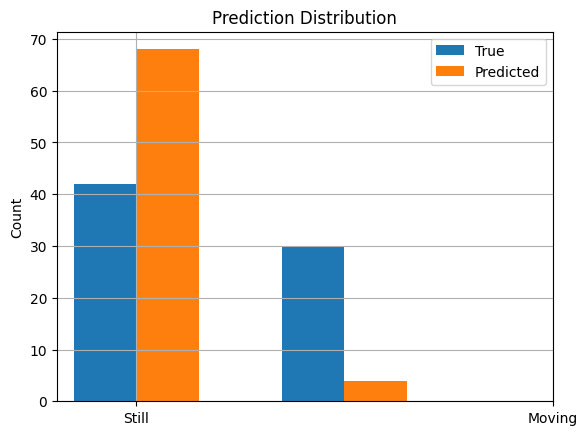

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# === Evaluate on test set ===
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        preds = model(x)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Convert probability → binary label
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
y_true_binary = np.array(y_true).astype(int)

# === Print metrics ===
print("Accuracy :", accuracy_score(y_true_binary, y_pred_binary))
print("Precision:", precision_score(y_true_binary, y_pred_binary))
print("Recall   :", recall_score(y_true_binary, y_pred_binary))
print("F1 Score :", f1_score(y_true_binary, y_pred_binary))
print("AUC-ROC  :", roc_auc_score(y_true_binary, y_pred))  

# === Plot prediction histogram ===
plt.hist([y_true_binary, y_pred_binary], bins=2, label=['True', 'Predicted'], align='left', rwidth=0.6)
plt.xticks([0, 1], ['Still', 'Moving'])
plt.ylabel("Count")
plt.title("Prediction Distribution")
plt.legend()
plt.grid(True)
plt.show()

## Heatmap

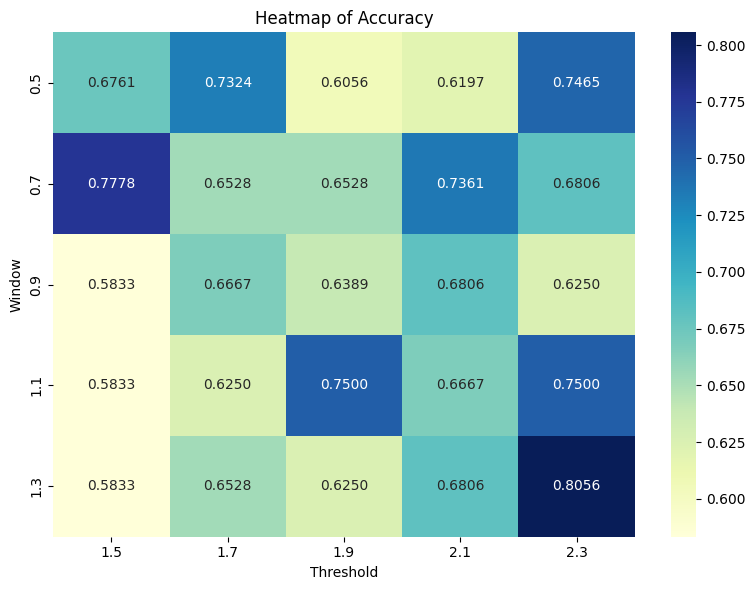

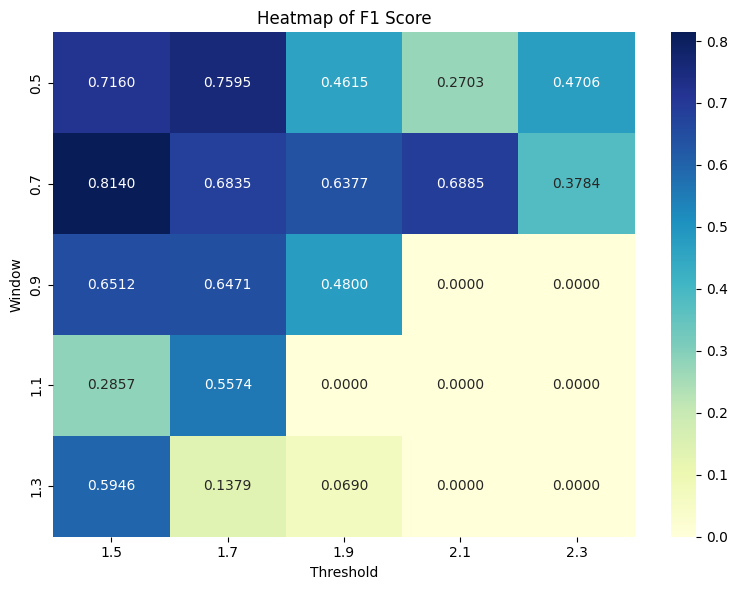

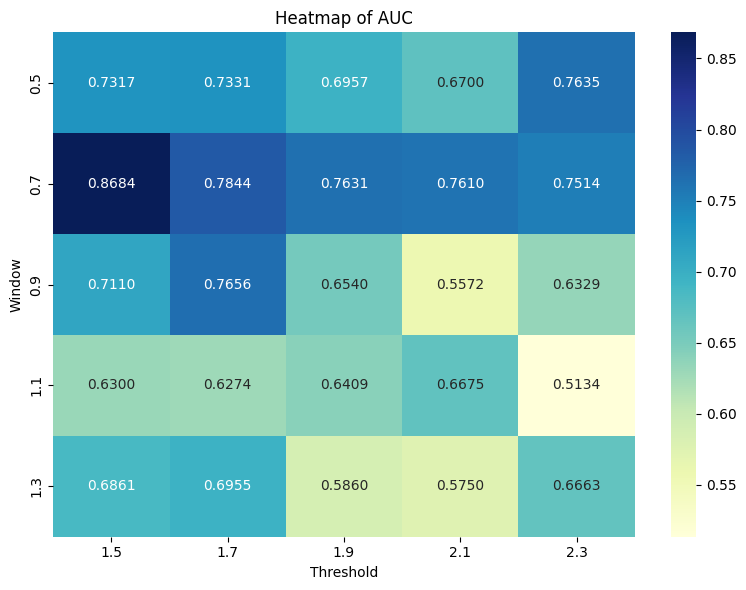

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original result data
data = [
    (0.50, 1.50, 0.6761, 0.7160, 0.7317),
    (0.50, 1.70, 0.7324, 0.7595, 0.7331),
    (0.50, 1.90, 0.6056, 0.4615, 0.6957),
    (0.50, 2.10, 0.6197, 0.2703, 0.6700),
    (0.50, 2.30, 0.7465, 0.4706, 0.7635),
    (0.70, 1.50, 0.7778, 0.8140, 0.8684),
    (0.70, 1.70, 0.6528, 0.6835, 0.7844),
    (0.70, 1.90, 0.6528, 0.6377, 0.7631),
    (0.70, 2.10, 0.7361, 0.6885, 0.7610),
    (0.70, 2.30, 0.6806, 0.3784, 0.7514),
    (0.90, 1.50, 0.5833, 0.6512, 0.7110),
    (0.90, 1.70, 0.6667, 0.6471, 0.7656),
    (0.90, 1.90, 0.6389, 0.4800, 0.6540),
    (0.90, 2.10, 0.6806, 0.0000, 0.5572),
    (0.90, 2.30, 0.6250, 0.0000, 0.6329),
    (1.10, 1.50, 0.5833, 0.2857, 0.6300),
    (1.10, 1.70, 0.6250, 0.5574, 0.6274),
    (1.10, 1.90, 0.7500, 0.0000, 0.6409),
    (1.10, 2.10, 0.6667, 0.0000, 0.6675),
    (1.10, 2.30, 0.7500, 0.0000, 0.5134),
    (1.30, 1.50, 0.5833, 0.5946, 0.6861),
    (1.30, 1.70, 0.6528, 0.1379, 0.6955),
    (1.30, 1.90, 0.6250, 0.0690, 0.5860),
    (1.30, 2.10, 0.6806, 0.0000, 0.5750),
    (1.30, 2.30, 0.8056, 0.0000, 0.6663),
]

# Create a DataFrame
df = pd.DataFrame(data, columns=["Window", "Threshold", "Accuracy", "F1", "AUC"])

# Define a plotting function
def plot_heatmap(metric: str, title: str):
    pivot_table = df.pivot(index="Window", columns="Threshold", values=metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f"Heatmap of {title}")
    plt.ylabel("Window")
    plt.xlabel("Threshold")
    plt.tight_layout()
    plt.show()

# Generate heatmaps
plot_heatmap("Accuracy", "Accuracy")
plot_heatmap("F1", "F1 Score")
plot_heatmap("AUC", "AUC")

## Loop

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy.signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import copy

# === Model Definition ===
class ImprovedTinyTransformer(nn.Module):
    def __init__(self, in_channels=384, time_len=3750, embed_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Conv1d(in_channels, embed_dim, kernel_size=3, padding=1)
        self.pos_embedding = nn.Parameter(torch.randn(1, time_len, embed_dim) * 0.01)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=128, dropout=0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(embed_dim)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x.permute(0, 2, 1)
        x = x + self.pos_embedding[:, :x.size(1), :]
        x = self.transformer(x)
        x = self.norm(x.mean(dim=1))
        x = self.regressor(x)
        return x.squeeze(-1)

# === Dataset Definition ===
class LFPBinaryDataset(Dataset):
    def __init__(self, lfp_segments, labels):
        self.segments = lfp_segments
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.segments[idx].copy(), dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

# === Evaluation Function ===
def evaluate_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    return acc, prec, rec, f1, auc

# === Grid Search Results Container ===
results = []
best_acc = 0
best_params = None

for window in np.arange(1.1, 1.6, 0.2):
    for threshold in np.arange(1.5, 2.5, 0.2):
        def generate_movement_labels(wheel_timestamps, wheel_position, stimOn_times, window, threshold):
            labels = []
            wheel_velocity = np.gradient(wheel_position, wheel_timestamps)
            for t_event in stimOn_times:
                mask = (wheel_timestamps >= t_event - window) & (wheel_timestamps <= t_event + window)
                if np.sum(mask) == 0:
                    continue
                avg_velocity = np.mean(wheel_velocity[mask])
                is_moving = int(abs(avg_velocity) > threshold)
                labels.append(is_moving)
            return labels

        motor_labels = generate_movement_labels(
            wheel_timestamps=wheel['timestamps'],
            wheel_position=wheel['position'],
            stimOn_times=stimOn_times,
            window=window,
            threshold=threshold
        )

        lfp_segments = extract_lfp_segments(sr_lf, stimOn_times, window=0.75)
        min_len = min(len(lfp_segments), len(motor_labels))
        lfp_segments = lfp_segments[:min_len]
        motor_labels = motor_labels[:min_len]

        dataset = LFPBinaryDataset(lfp_segments, motor_labels)
        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
        train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=8)
        test_loader = DataLoader(test_set, batch_size=8)

        model = ImprovedTinyTransformer().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.BCELoss()
        device = next(model.parameters()).device

        best_val_loss = float('inf')
        best_model_state = None

        for epoch in range(10):
            model.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                preds = model(x)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()

            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    preds_val = model(x_val)
                    loss_val = criterion(preds_val, y_val)
                    total_val_loss += loss_val.item()

            avg_val_loss = total_val_loss / len(val_loader)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())

        model.load_state_dict(best_model_state)

        # Evaluate on test set
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                preds = model(x_test)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_test.cpu().numpy())

        acc, prec, rec, f1, auc = evaluate_metrics(np.array(all_labels), np.array(all_preds))
        print(f"Window={window:.2f}, Threshold={threshold:.2f} => Acc: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        results.append({
            "window": round(window, 2),
            "threshold": round(threshold, 2),
            "accuracy": acc,
            "f1": f1,
            "auc": auc
        })

        if acc > best_acc:
            best_acc = acc
            best_params = (window, threshold)

print(f"\n🎯 Best Accuracy: {best_acc:.4f} at Window={best_params[0]:.2f}, Threshold={best_params[1]:.2f}")

2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:49 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeomMap field), returning defaults
2025-04-21 01:41:50 WARNING  spikeglx.py:690  Meta data doesn't have geometry (snsShankMap/snsGeo

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Function to plot heatmap for a selected metric
def plot_metric_heatmap(metric: str, title: str):
    pivot_table = results_df.pivot(index="window", columns="threshold", values=metric)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.title(f"Heatmap of {title}")
    plt.ylabel("Window")
    plt.xlabel("Threshold")
    plt.tight_layout()
    plt.show()

# Plot all 3 metrics
plot_metric_heatmap("accuracy", "Accuracy")
plot_metric_heatmap("f1", "F1 Score")
plot_metric_heatmap("auc", "AUC")